<a href="https://colab.research.google.com/github/xDevICCI/TallerDeepLearning/blob/main/VictorGodoy_XXXXXXXXX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='red'>WARNING-1: No se aceptan soluciones que usen metodologías distintas a las vistas en clases.</font>

<font color='orange'>Está permitido usar los códigos de los ejemplos vistos en clases.</font>



# 0) Cambiar el nombre del archivo

<font color='red'>WARNING-2: CAMBIA EL NOMBRE DEL ARCHIVO ipynb INCLUYENDO TU NOMBRE Y RUT</font>

Ejemplo, si tu nombres es Pedro Perez y RUT es 12.345.678-9, el nombre de este archivo debe cambiarse de "Nombre_Rut.ipynb" a "Pedro_Perez_12345678-9.ipynb"


🏷️ Nombre del proyecto:
# Predicción de Fallas y Retrasos en Manufactura con LSTM

# 📊 Descripción del dataset y problema a resolver:

Este proyecto aborda un problema de clasificación multiclase en un entorno de manufactura híbrida. A partir de un conjunto de datos que contiene información de trabajos asignados a distintas máquinas (incluyendo tipo de operación, material utilizado, tiempos programados y reales, consumo energético y estado final del trabajo), se busca predecir el campo Job_Status, que puede tomar los siguientes valores:

- Completed: el trabajo se ejecutó correctamente dentro del rango esperado.
- Delayed: el trabajo se ejecutó pero con retrasos respecto al plan.
- Failed: el trabajo no se completó o tuvo problemas críticos.

La solución se implementará utilizando modelos de Deep Learning como redes LSTM o Multilayer Perceptrons (MLP) para identificar patrones en los datos que permitan anticipar fallos y retrasos antes de que ocurran.

# 1) Carga de datos y librerías a utilizar

(2 puntos)

Incluya aquí todas las librerías a utilizar en este código.

De una ubicación de los datos para ser descargados.

Por ejemplo: Los datos se encuentran en `https://www.dropbox.com/s/p94odo87ekacd46/bikes3.zip`




In [1]:
!pip install tensorflow

In [2]:
# Carga de librerías principales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Modelado con Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

# Carga de datos
df = pd.read_csv("sample_data/hybrid_manufacturing_categorical.csv")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 2) Definición de parámetros

(1 punto)

Defina los parámetros necesarios. Por ejemplo: `fpath` (path de los archivos), `BATCH_SIZE`, etc.



In [3]:
# Ruta del archivo
fpath = "sample_data/hybrid_manufacturing_categorical.csv"

# Parámetros del modelo
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
SEED = 42
TEST_SIZE = 0.2


# 3) Pre-procesamiento y Data augmentation (si es necesario, investigue métodos para el aumento de los datos artificialente)

(2 puntos)

Defina los parámetros necesarios, haga los cambios necesarios considerando el tamaño de las imágenes, señales, etc.



In [ ]:
# Eliminamos filas con datos faltantes.
df = df.dropna()


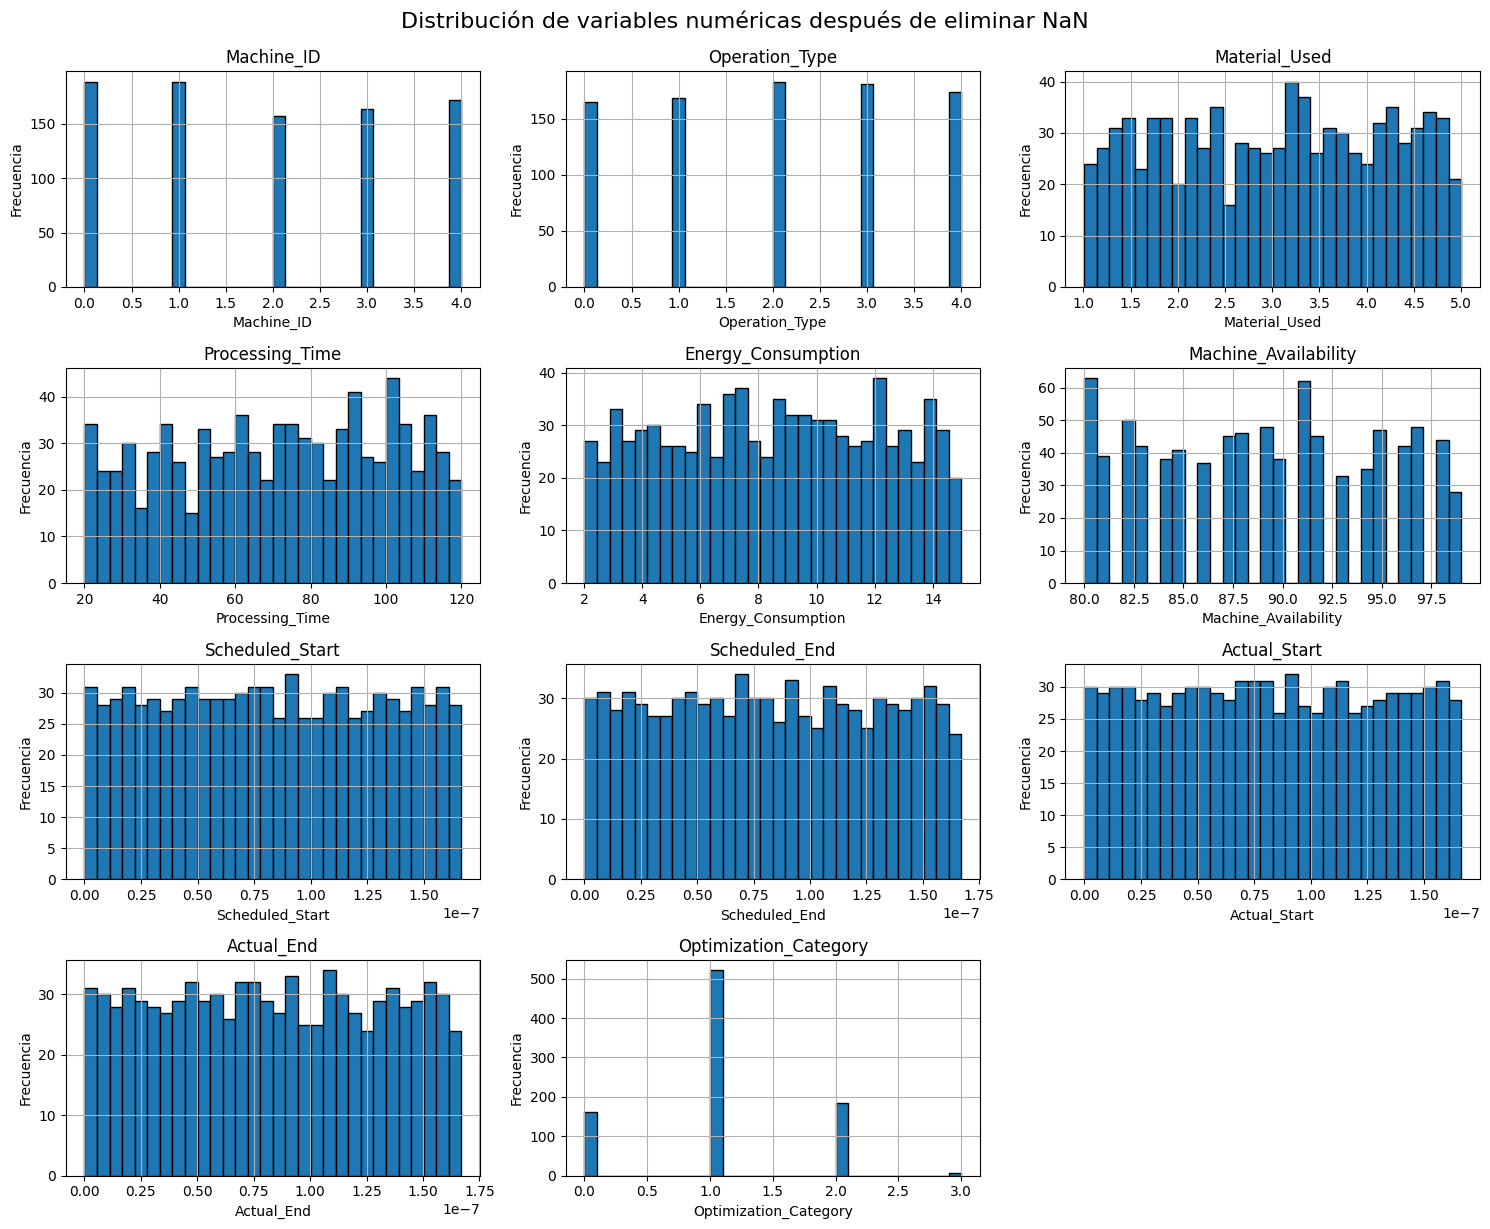

In [6]:
# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Crear histogramas
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i + 1)
    df[col].hist(bins=30, edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("Distribución de variables numéricas después de eliminar NaN", fontsize=16, y=1.02)
plt.show()

<ipython-input-7-315cf34cd31b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Job_Status', order=df['Job_Status'].value_counts().index, palette='pastel')


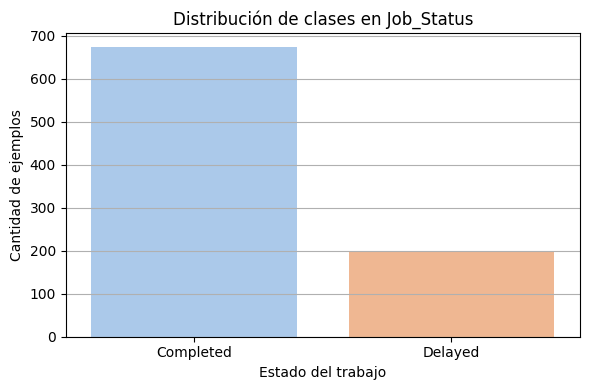

In [7]:
# Visualizar distribución de clases en Job_Status
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Job_Status', order=df['Job_Status'].value_counts().index, palette='pastel')
plt.title("Distribución de clases en Job_Status")
plt.xlabel("Estado del trabajo")
plt.ylabel("Cantidad de ejemplos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [5]:
# Convertimos las columnas categóricas
label_cols = ['Machine_ID', 'Operation_Type', 'Optimization_Category']
df[label_cols] = df[label_cols].astype(str)

for col in label_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Convertimos fechas a minutos desde inicio
for col in ['Scheduled_Start', 'Scheduled_End', 'Actual_Start', 'Actual_End']:
    df[col] = pd.to_datetime(df[col])
    df[col] = (df[col] - df[col].min()).dt.total_seconds() / 60  # en minutos

# Definimos X (features) e y (target)
X = df.drop(columns=['Job_ID', 'Job_Status'])
y = df['Job_Status']

# Codificamos y (clasificación multiclase)
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Normalizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat, test_size=TEST_SIZE, random_state=SEED, stratify=y_cat)


# 4) Definir el modelo

(1 punto)

Defina la clase donde se decriba y declare el o los modelos a usar.



In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

input_dim = X_train.shape[1]
num_classes = y_cat.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)), # Capa densa con 128 neuronas
    Dropout(0.3), # Previene sobreajuste
    Dense(64, activation='relu'), # Otra capa para mayor abstracción
    Dropout(0.2), # Regularización adicional
    Dense(num_classes, activation='softmax') # Capa de salida (clasificación multiclase)
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,922 (38.76 KB)

 Trainable params: 9,922 (38.76 KB)

 Non-trainable params: 0 (0.00 B)

We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

# 5) Entrenar el modelo

(4 puntos)

Entre el modelo definido en los pasos anteriores

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6172 - loss: 0.6373
Epoch 1: val_loss improved from inf to 0.53929, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.6223 - loss: 0.6343 - val_accuracy: 0.7643 - val_loss: 0.5393
Epoch 2/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7188 - loss: 0.5862
Epoch 2: val_loss improved from 0.53929 to 0.52864, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7614 - loss: 0.5525 - val_accuracy: 0.7643 - val_loss: 0.5286
Epoch 3/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5651
Epoch 3: val_loss improved from 0.52864 to 0.51870, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7703 - loss: 0.5202 - val_accuracy: 0.7643 - val_loss: 0.5187
Epoch 4/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7812 - loss: 0.5152
Epoch 4: val_loss improved from 0.51870 to 0.51745, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7693 - loss: 0.4994 - val_accuracy: 0.7643 - val_loss: 0.5174
Epoch 5/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7188 - loss: 0.5514
Epoch 5: val_loss improved from 0.51745 to 0.50941, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7841 - loss: 0.4792 - val_accuracy: 0.7643 - val_loss: 0.5094
Epoch 6/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7812 - loss: 0.4276
Epoch 6: val_loss improved from 0.50941 to 0.49931, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7857 - loss: 0.4557 - val_accuracy: 0.7500 - val_loss: 0.4993
Epoch 7/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8438 - loss: 0.4144
Epoch 7: val_loss improved from 0.49931 to 0.48237, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8055 - loss: 0.4296 - val_accuracy: 0.7571 - val_loss: 0.4824
Epoch 8/20
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7752 - loss: 0.4199  
Epoch 8: val_loss improved from 0.48237 to 0.47718, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7782 - loss: 0.4216 - val_accuracy: 0.7429 - val_loss: 0.4772
Epoch 9/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7881 - loss: 0.4054
Epoch 9: val_loss improved from 0.47718 to 0.47303, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7879 - loss: 0.4065 - val_accuracy: 0.7286 - val_loss: 0.4730
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7931 - loss: 0.3784
Epoch 10: val_loss improved from 0.47303 to 0.47017, saving model to mejor_modelo_mlp.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7925 - loss: 0.3796 - val_accuracy: 0.7143 - val_loss: 0.4702
Epoch 11/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8182 - loss: 0.3688
Epoch 11: val_loss did not improve from 0.47017
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8165 - loss: 0.3709 - val_accuracy: 0.7286 - val_loss: 0.4770
Epoch 12/20
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7987 - loss: 0.3881 
Epoch 12: val_loss did not improve from 0.47017
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7994 - loss: 0.3868 - val_accuracy: 0.7143 - val_loss: 0.4776
Epoch 13/20
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8026 - loss: 0.3675 
Epoch 13: val_loss did not improve from 0.47017
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8016 - loss: 0.3695 - val_accuracy: 0.6786 - val_loss: 0.4830
Epoch 14/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.7500 - loss: 0.3598
Epoch 14: val_loss did not improve from 0.47017

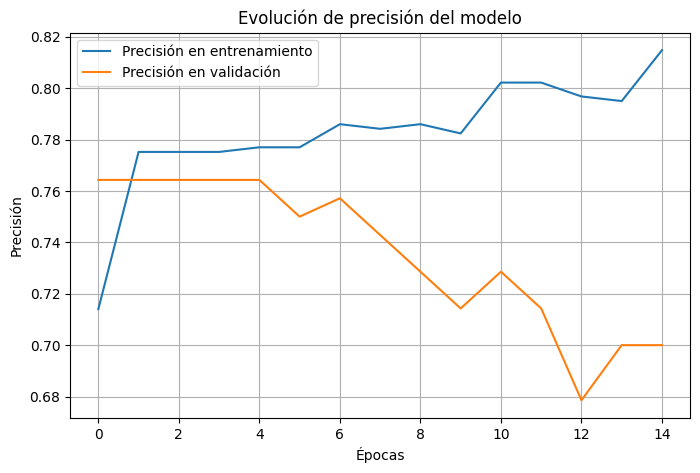

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Callbacks
# EarlyStopping: detiene el entrenamiento si la validación deja de mejorar (para evitar sobreajuste).
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'mejor_modelo_mlp.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Entrenamiento
# ModelCheckpoint: guarda el mejor modelo automáticamente durante el entrenamiento.
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Visualización de la precisión
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Evolución de precisión del modelo")
plt.legend()
plt.grid(True)
plt.show()


🔹 Curva de entrenamiento (azul): muestra una tendencia general ascendente, llegando a ~82% de precisión en la última época, es decir, el modelo sigue aprendiendo y ajustando sus pesos correctamente sobre los datos de entrenamiento.

🔸 Curva de validación (naranja): muestra cerca del 76%, pero empieza a descender a partir de la época 5-6. Desde la época 7 en adelante, hay una caída sostenida de la precisión de validación, con un punto mínimo (~68%) en la época 12, seguido de una leve recuperación.



# Mejora del modelo a partir del resultado anterior usando class_weight

In [1]:
from sklearn.utils.class_weight import compute_class_weight

# Etiquetas verdaderas en forma original (no one-hot)
y_train_labels = np.argmax(y_train, axis=1)

# Calcular pesos
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Convertir a diccionario
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Pesos de clase:", class_weights_dict)

NameError: name 'np' is not defined

In [ ]:
# Entrenamiento
# ModelCheckpoint: guarda el mejor modelo automáticamente durante el entrenamiento.
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Visualización de la precisión
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Evolución de precisión del modelo")
plt.legend()
plt.grid(True)
plt.show()

# 6) Evaluación de desempeño

(2 puntos)

Calcule el accuracy en el training, validation y testing.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

   Completed       0.77      0.96      0.86       135
     Delayed       0.17      0.03      0.04        40

    accuracy                           0.75       175
   macro avg       0.47      0.49      0.45       175
weighted avg       0.63      0.75      0.67       175



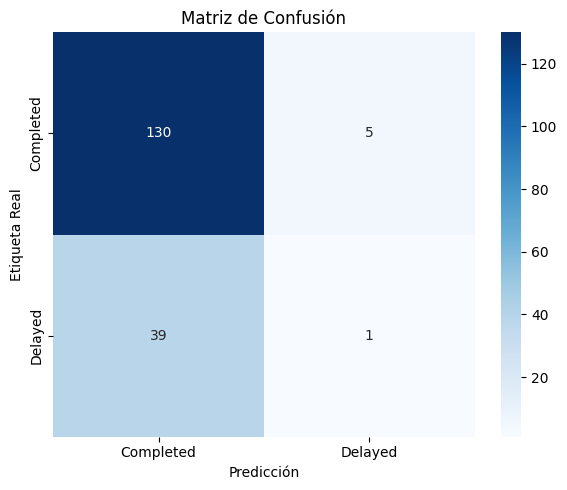

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predicciones
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte de métricas
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=le_y.classes_))

# Matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_,
            yticklabels=le_y.classes_)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()


Precisión general (accuracy): 75%, esto indica que está fuertemente sesgado hacia la clase Completed.

Completed tiene: Precision (0.77), Recall (0.96), F1-Score (0.86).

Interpretación del modelo: identifica la mayoría de los trabajos completados sin problemas.

Delayed: Precision (0.17), Recall (0.03), F1-score (0.04).

Interpretación del modelo: casi no detecta retrasos, la matriz de confusión indica 39 de 40 trabajos realmente retrasados fueron clasificados como Completed.

Metricas promediadas: en Macro F1-Score (0.45) y Weighted F1-Score (0.67).

Estas cifras bajan debido al esempeño pobre sobre la clase minoritaria.

# 7) Evaluación aleatoria (de una imagen, señal etc.) del testing

(1 punto)

Despliegue una señal, imagen, cadena de texto, etc.,  aleatoria del testing con la clasificación proporcionada por el Transformer entrenado.